/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/1664168760.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][(signals['short_mavg'] > signals['long_mavg']) & (signals['rsi'] < rsi_overbought)] = 1  # Lon

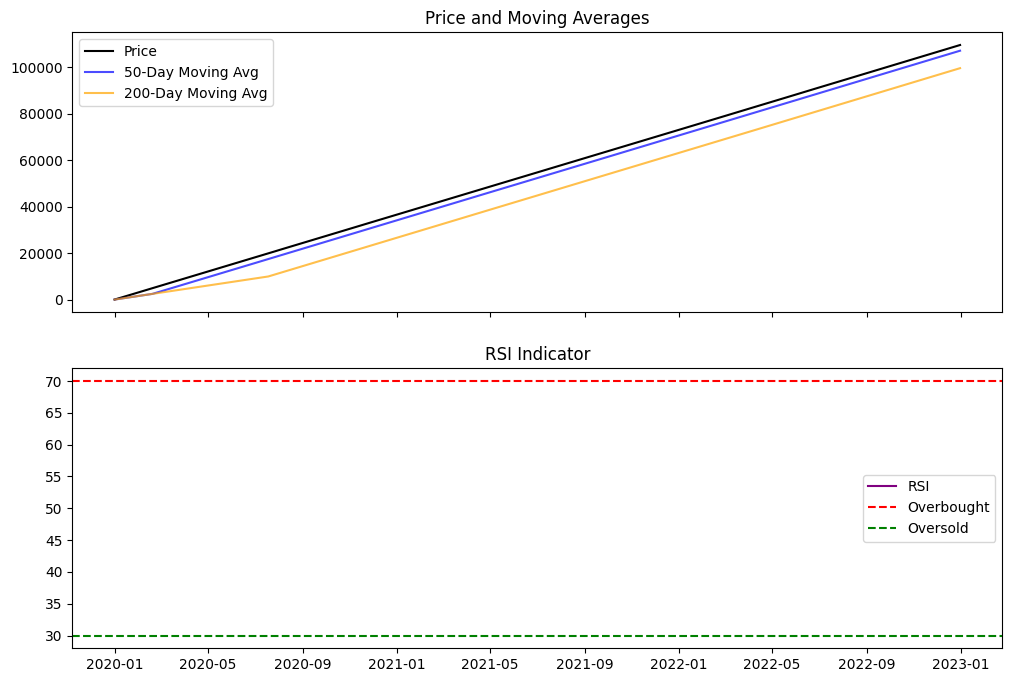

Final Portfolio Value: 10000.00
                    price     short_mavg     long_mavg  rsi  signal  \
2022-12-27  109269.149495  106817.084031  99300.983328  NaN       0   
2022-12-28  109370.604754  106917.172740  99401.206579  NaN       0   
2022-12-29  109470.708646  107017.265067  99501.418656  NaN       0   
2022-12-30  109572.173926  107117.393604  99601.624237  NaN       0   
2022-12-31  109672.012493  107217.483567  99701.822525  NaN       0   

            positions  daily_returns  portfolio_returns  cumulative_returns  
2022-12-27        0.0       0.000915                0.0             10000.0  
2022-12-28        0.0       0.000928                0.0             10000.0  
2022-12-29        0.0       0.000915                0.0             10000.0  
2022-12-30        0.0       0.000927                0.0             10000.0  
2022-12-31        0.0       0.000911                0.0             10000.0  


/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/1664168760.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Final Portfolio Value: {signals['cumulative_returns'][-1]:.2f}")


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated Strategy Settings
def backtest_strategy(prices, short_window=50, long_window=200, rsi_period=14, rsi_overbought=70, rsi_oversold=30):
    # Create signals
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    
    # Moving averages for trend following (used for long/short decision)
    signals['short_mavg'] = prices.rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = prices.rolling(window=long_window, min_periods=1).mean()
    
    # RSI calculation
    delta = prices.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))
    
    # Generate long/short signals based on moving average crossover and RSI
    signals['signal'] = 0  # Default no action
    
    # Buy signal (go long): Short moving average crosses above long moving average and RSI not overbought
    signals['signal'][(signals['short_mavg'] > signals['long_mavg']) & (signals['rsi'] < rsi_overbought)] = 1  # Long
    
    # Sell signal (go short): Short moving average crosses below long moving average and RSI not oversold
    signals['signal'][(signals['short_mavg'] < signals['long_mavg']) & (signals['rsi'] > rsi_oversold)] = -1  # Short

    # Shift signal by 1 to represent decision made at the end of the day for next day
    signals['positions'] = signals['signal'].shift()
    
    # Return the strategy and signals
    return signals

# Simulate P&L from signals
def simulate_trades(signals, initial_capital=10000):
    # Calculate daily returns
    signals['daily_returns'] = signals['price'].pct_change()
    
    # Apply positions to calculate portfolio value
    signals['portfolio_returns'] = signals['daily_returns'] * signals['positions']
    
    # Calculate cumulative returns
    signals['cumulative_returns'] = (1 + signals['portfolio_returns']).cumprod() * initial_capital
    
    return signals

# Plotting the signals with cumulative returns
def plot_strategy(signals):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Price and moving averages
    ax1.plot(signals.index, signals['price'], label='Price', color='black')
    ax1.plot(signals.index, signals['short_mavg'], label='50-Day Moving Avg', color='blue', alpha=0.7)
    ax1.plot(signals.index, signals['long_mavg'], label='200-Day Moving Avg', color='orange', alpha=0.7)
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # RSI Indicator
    ax2.plot(signals.index, signals['rsi'], label='RSI', color='purple')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold')
    ax2.set_title('RSI Indicator')
    ax2.legend()
    
    plt.show()

# Example usage with simulated price data
if __name__ == "__main__":
    # Simulated price data (you can replace this with real historical data)
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2022-12-31')
    prices = pd.Series(np.random.normal(100, 2, len(dates)).cumsum(), index=dates)

    # Backtest and simulate strategy
    signals = backtest_strategy(prices)
    signals = simulate_trades(signals)

    # Plot results
    plot_strategy(signals)
    
    # Show final portfolio value and cumulative returns
    print(f"Final Portfolio Value: {signals['cumulative_returns'][-1]:.2f}")
    print(signals.tail())


In [2]:
import numpy as np
import pandas as pd

def calculate_sharpe_ratio(returns, risk_free_rate=0.01, periods_per_year=252):
    """
    Calculate the Sharpe Ratio of a strategy based on returns.

    Parameters:
    - returns: A pandas Series of daily returns (or returns at any other interval).
    - risk_free_rate: The annual risk-free rate as a decimal (e.g., 0.01 for 1%).
    - periods_per_year: The number of periods per year (e.g., 252 for daily returns).

    Returns:
    - sharpe_ratio: The Sharpe Ratio of the strategy.
    """
    # Calculate the average excess return (annualized)
    average_return = returns.mean() * periods_per_year
    
    # Annualize the risk-free rate
    annualized_rf = risk_free_rate / periods_per_year
    
    # Calculate the excess returns
    excess_returns = average_return - annualized_rf
    
    # Calculate the standard deviation of returns (annualized)
    std_dev = returns.std() * np.sqrt(periods_per_year)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_returns / std_dev
    
    return sharpe_ratio

# Example usage
# Assume `daily_returns` is a pandas Series of daily returns from a strategy
daily_returns = pd.Series([0.001, 0.002, -0.001, 0.004, -0.003, 0.002, -0.001])
sharpe_ratio = calculate_sharpe_ratio(daily_returns)
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 3.825702273265532


In [3]:
import numpy as np
import pandas as pd

def calculate_sharpe_ratio(returns, risk_free_rate=0.01, periods_per_year=252):
    """
    Calculate the Sharpe Ratio of a strategy based on returns.

    Parameters:
    - returns: A pandas Series of daily returns (or returns at any other interval).
    - risk_free_rate: The annual risk-free rate as a decimal (e.g., 0.01 for 1%).
    - periods_per_year: The number of periods per year (e.g., 252 for daily returns).

    Returns:
    - sharpe_ratio: The Sharpe Ratio of the strategy.
    """
    # Ensure the input is a pandas Series for compatibility
    if not isinstance(returns, pd.Series):
        raise ValueError("Returns should be a pandas Series.")

    # Calculate the average excess return (annualized)
    average_return = returns.mean() * periods_per_year
    
    # Annualize the risk-free rate (per period)
    annualized_rf = risk_free_rate / periods_per_year
    
    # Calculate the excess returns
    excess_returns = average_return - annualized_rf
    
    # Calculate the standard deviation of returns (annualized)
    std_dev = returns.std(ddof=0) * np.sqrt(periods_per_year)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_returns / std_dev
    
    return sharpe_ratio

# Example usage
# Assume `daily_returns` is a pandas Series of daily returns from a strategy
daily_returns = pd.Series([0.001, 0.002, -0.001, 0.004, -0.003, 0.002, -0.001])
sharpe_ratio = calculate_sharpe_ratio(daily_returns)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 4.13


In [5]:
import pandas as pd
import numpy as np

def backtest_strategy(prices, rsi_period=14, overbought=70, oversold=30, initial_capital=10000, risk_per_trade=0.01):
    """
    Backtest an RSI-based long/short strategy.

    Parameters:
    - prices: A pandas Series of historical prices.
    - rsi_period: The period to calculate the RSI.
    - overbought: RSI value above which a short position is taken.
    - oversold: RSI value below which a long position is taken.
    - initial_capital: The initial amount of capital for the strategy.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - results: A DataFrame containing signals, positions, and portfolio value over time.
    """

    # Create a DataFrame to hold the prices and calculated RSI values
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the RSI
    delta = prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))

    # Define the signals based on RSI values
    signals['long_signal'] = (signals['rsi'] < oversold).astype(int)
    signals['short_signal'] = (signals['rsi'] > overbought).astype(int)
    
    # Initialize the columns for the backtest
    signals['position'] = 0
    signals['capital'] = initial_capital
    signals['holdings'] = 0
    signals['cash'] = initial_capital
    signals['total_value'] = initial_capital
    
    # Variable to track the number of units held
    units_held = 0

    # Simulate trades based on the signals
    for i in range(1, len(signals)):
        price = signals['price'].iloc[i]
        prev_position = signals['position'].iloc[i - 1]

        # Check for long signal
        if signals['long_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 0.98
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = position_size
            signals.at[signals.index[i], 'position'] = 1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - (units_held * price)

        # Check for short signal
        elif signals['short_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 1.02
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = -position_size
            signals.at[signals.index[i], 'position'] = -1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - abs(units_held * price)

        # If already holding a position, update the portfolio value
        else:
            signals.at[signals.index[i], 'position'] = prev_position
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1]

        # Calculate the total portfolio value
        signals.at[signals.index[i], 'total_value'] = signals['holdings'].iloc[i] + signals['cash'].iloc[i]

    return signals

def calculate_position_size(price, stop_loss_level, available_cash, risk_per_trade):
    """
    Calculate the number of units to buy or short based on risk per trade.

    Parameters:
    - price: The price at which the asset is being bought or sold.
    - stop_loss_level: The stop-loss price level.
    - available_cash: The cash available for trading.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - position_size: The number of units to buy or sell based on the risk.
    """
    risk_per_unit = abs(price - stop_loss_level)
    risk_amount = available_cash * risk_per_trade
    position_size = risk_amount // risk_per_unit if risk_per_unit > 0 else 0

    return int(position_size)

# Example price data (e.g., daily prices)
price_data = pd.Series([100, 101, 102, 103, 100, 97, 95, 98, 102, 104])

# Backtest the strategy
results = backtest_strategy(price_data)

# View the results
print(results.head())


   price    rsi  long_signal  short_signal  position  capital  holdings  \
0    100    NaN            0             0         0    10000         0   
1    101  100.0            0             1        -1    10000     -4949   
2    102  100.0            0             1        -1    10000     -4998   
3    103  100.0            0             1        -1    10000     -5047   
4    100   50.0            0             0        -1    10000     -4900   

    cash  total_value  
0  10000        10000  
1   5051          102  
2   5051           53  
3   5051            4  
4   5051          151  


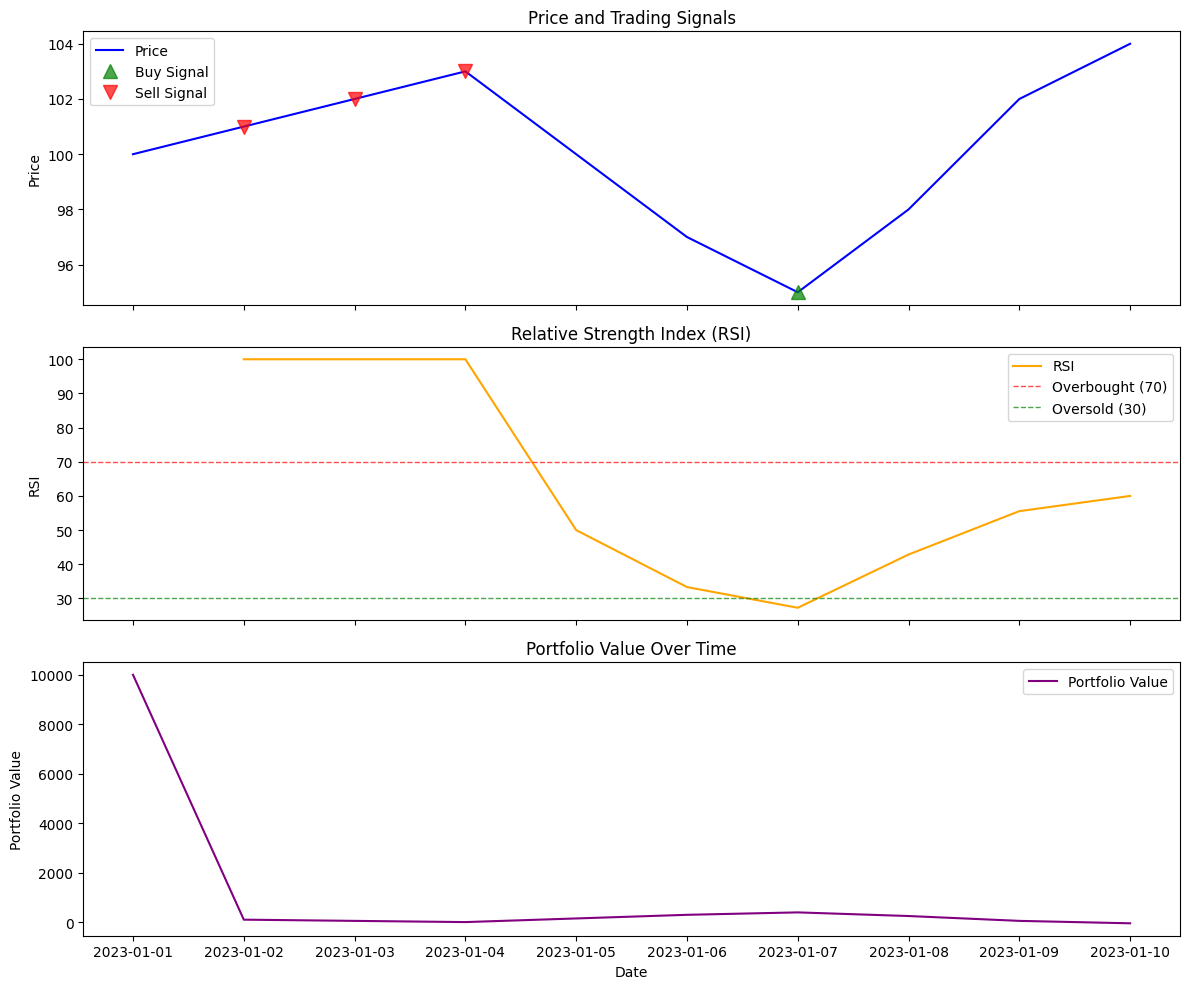

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def backtest_strategy(prices, rsi_period=14, overbought=70, oversold=30, initial_capital=10000, risk_per_trade=0.01):
    """
    Backtest an RSI-based long/short strategy.

    Parameters:
    - prices: A pandas Series of historical prices.
    - rsi_period: The period to calculate the RSI.
    - overbought: RSI value above which a short position is taken.
    - oversold: RSI value below which a long position is taken.
    - initial_capital: The initial amount of capital for the strategy.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - results: A DataFrame containing signals, positions, and portfolio value over time.
    """

    # Create a DataFrame to hold the prices and calculated RSI values
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the RSI
    delta = prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))

    # Define the signals based on RSI values
    signals['long_signal'] = (signals['rsi'] < oversold).astype(int)
    signals['short_signal'] = (signals['rsi'] > overbought).astype(int)
    
    # Initialize the columns for the backtest
    signals['position'] = 0
    signals['capital'] = initial_capital
    signals['holdings'] = 0
    signals['cash'] = initial_capital
    signals['total_value'] = initial_capital
    
    # Variable to track the number of units held
    units_held = 0

    # Simulate trades based on the signals
    for i in range(1, len(signals)):
        price = signals['price'].iloc[i]
        prev_position = signals['position'].iloc[i - 1]

        # Check for long signal
        if signals['long_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 0.98
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = position_size
            signals.at[signals.index[i], 'position'] = 1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - (units_held * price)

        # Check for short signal
        elif signals['short_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 1.02
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = -position_size
            signals.at[signals.index[i], 'position'] = -1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - abs(units_held * price)

        # If already holding a position, update the portfolio value
        else:
            signals.at[signals.index[i], 'position'] = prev_position
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1]

        # Calculate the total portfolio value
        signals.at[signals.index[i], 'total_value'] = signals['holdings'].iloc[i] + signals['cash'].iloc[i]

    return signals

def calculate_position_size(price, stop_loss_level, available_cash, risk_per_trade):
    """
    Calculate the number of units to buy or short based on risk per trade.

    Parameters:
    - price: The price at which the asset is being bought or sold.
    - stop_loss_level: The stop-loss price level.
    - available_cash: The cash available for trading.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - position_size: The number of units to buy or sell based on the risk.
    """
    risk_per_unit = abs(price - stop_loss_level)
    risk_amount = available_cash * risk_per_trade
    position_size = risk_amount // risk_per_unit if risk_per_unit > 0 else 0

    return int(position_size)

def plot_strategy(results):
    """
    Plot the trading strategy results including price, RSI, and portfolio value.

    Parameters:
    - results: A DataFrame containing the price, RSI, signals, and portfolio value from the backtest.
    """
    # Set up the figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot the price and signals on the first subplot
    ax1.plot(results.index, results['price'], label='Price', color='blue')
    ax1.set_ylabel('Price')
    ax1.set_title('Price and Trading Signals')

    # Plot buy and sell signals
    buy_signals = results[results['long_signal'] == 1]
    sell_signals = results[results['short_signal'] == 1]

    ax1.plot(buy_signals.index, buy_signals['price'], '^', markersize=10, color='green', label='Buy Signal', alpha=0.7)
    ax1.plot(sell_signals.index, sell_signals['price'], 'v', markersize=10, color='red', label='Sell Signal', alpha=0.7)

    ax1.legend()

    # Plot the RSI on the second subplot
    ax2.plot(results.index, results['rsi'], label='RSI', color='orange')
    ax2.axhline(y=70, color='red', linestyle='--', linewidth=1, label='Overbought (70)', alpha=0.7)
    ax2.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Oversold (30)', alpha=0.7)
    ax2.set_ylabel('RSI')
    ax2.set_title('Relative Strength Index (RSI)')
    ax2.legend()

    # Plot the portfolio value on the third subplot
    ax3.plot(results.index, results['total_value'], label='Portfolio Value', color='purple')
    ax3.set_ylabel('Portfolio Value')
    ax3.set_xlabel('Date')
    ax3.set_title('Portfolio Value Over Time')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Example price data (e.g., daily prices)
price_data = pd.Series([100, 101, 102, 103, 100, 97, 95, 98, 102, 104], 
                       index=pd.date_range(start='2023-01-01', periods=10, freq='D'))

# Run the backtest
results = backtest_strategy(price_data)

# Plot the strategy
plot_strategy(results)


In [18]:
import pandas as pd
import numpy as np

def backtest_strategy(data=None, csv_file=None, rsi_period=14, short_ma=5, medium_ma=20, long_ma1=50, long_ma2=200, 
                      overbought=80, oversold=20, initial_capital=10000, risk_per_trade=0.01):
    """
    Backtest an RSI and multi-MA-based strategy with the option to load data from a CSV file (Yahoo Finance format).
    
    Parameters:
    - data: A pandas DataFrame of historical prices (expects 'Adj Close' column).
    - csv_file: A CSV file path for loading Yahoo Finance-like data.
    - rsi_period: The period to calculate the RSI.
    - short_ma, medium_ma, long_ma1, long_ma2: Periods for the moving averages.
    - overbought: RSI value above which a short position is taken.
    - oversold: RSI value below which a long position is taken.
    - initial_capital: The initial amount of capital for the strategy.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - results: A DataFrame containing signals, positions, and portfolio value over time.
    """

    # Load data if CSV file is provided
    if csv_file:
        data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
        data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]  # Select relevant columns

    if data is None:
        raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

    prices = data['Adj Close']  # Use the 'Adj Close' for calculations

    # Create a DataFrame to hold the prices and calculated indicators
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the RSI
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))

    # Calculate moving averages
    signals['short_ma'] = prices.rolling(window=short_ma).mean()
    signals['medium_ma'] = prices.rolling(window=medium_ma).mean()
    signals['long_ma1'] = prices.rolling(window=long_ma1).mean()
    signals['long_ma2'] = prices.rolling(window=long_ma2).mean()

    # Define the signals based on RSI and MA crossovers
    signals['long_signal'] = ((signals['rsi'] < oversold) & 
                              (signals['short_ma'] > signals['medium_ma']) &
                              (signals['short_ma'] > signals['long_ma1']) &
                              (signals['short_ma'] > signals['long_ma2'])).astype(int)

    signals['short_signal'] = ((signals['rsi'] > overbought) & 
                               (signals['short_ma'] < signals['medium_ma']) &
                               (signals['short_ma'] < signals['long_ma1']) &
                               (signals['short_ma'] < signals['long_ma2'])).astype(int)

    # Initialize the columns for the backtest
    signals['position'] = 0
    signals['capital'] = initial_capital
    signals['holdings'] = 0
    signals['cash'] = initial_capital
    signals['total_value'] = initial_capital

    return signals

def simulate_trades(data=None, csv_file=None, strategy_fn=None):
    """
    Simulate trades for a given strategy, supporting both DataFrame and CSV input.

    Parameters:
    - data: A pandas DataFrame of historical prices (expects 'Adj Close' column).
    - csv_file: A CSV file path for loading Yahoo Finance-like data.
    - strategy_fn: Function to generate trading signals (e.g., backtest_strategy).

    Returns:
    - results: The trading results and portfolio performance over time.
    """

    # Load data if CSV file is provided
    if csv_file:
        data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
        data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]  # Select relevant columns

    if data is None:
        raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

    if strategy_fn is None:
        raise ValueError("A strategy function must be provided.")

    # Get the strategy signals and positions
    signals = strategy_fn(data=data)

    # Implement your trading logic here to simulate trades based on the signals
    # For example, manage position sizing, stop-loss, etc.

    # Return the result (can include portfolio value, positions, etc.)
    return signals

# Example usage with CSV file
file_path = './ALO.PA.csv'
signals = backtest_strategy(csv_file=file_path)
results = simulate_trades(csv_file=file_path, strategy_fn=backtest_strategy)

# Example usage with DataFrame
# price_data = pd.DataFrame({...})  # Assuming you have already loaded a DataFrame
# signals = backtest_strategy(data=price_data)
# results = simulate_trades(data=price_data, strategy_fn=backtest_strategy)


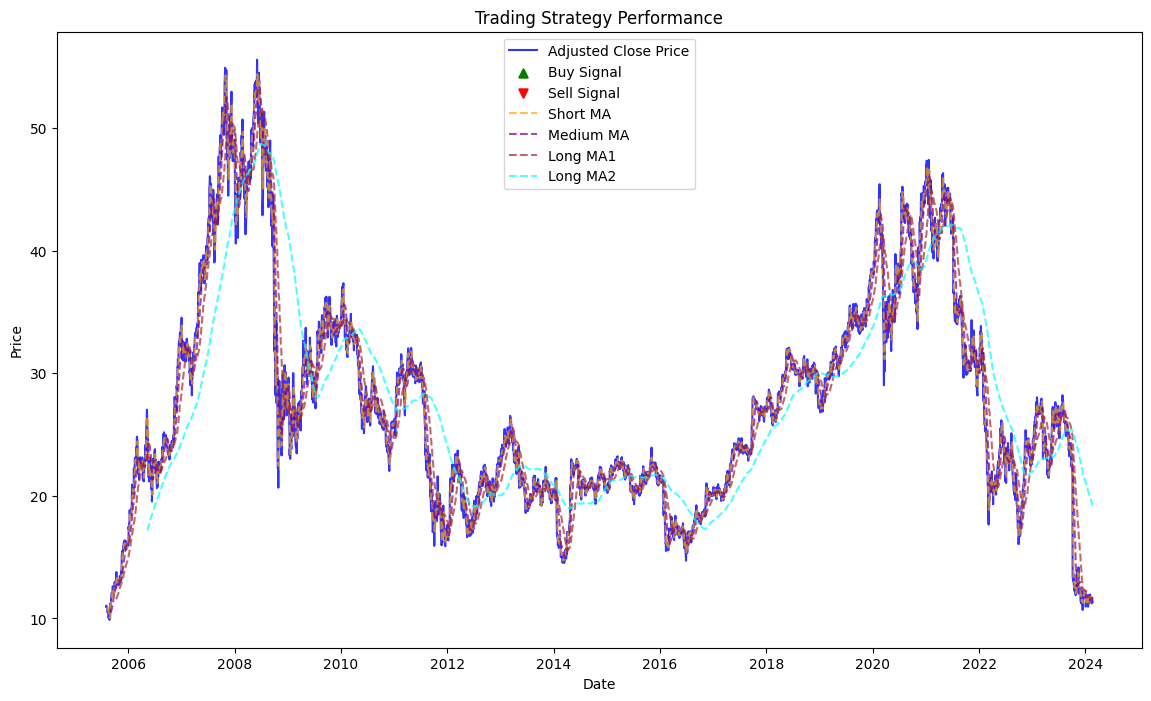

In [20]:
def plot_strategy(data=None, csv_file=None, strategy_fn=None):
    """
    Plot the trading strategy using data either from a DataFrame or a CSV file.

    Parameters:
    - data: A pandas DataFrame of historical prices (expects 'Adj Close' column).
    - csv_file: A CSV file path for loading Yahoo Finance-like data.
    - strategy_fn: Function to generate trading signals (e.g., backtest_strategy).

    Returns:
    - None: The function plots the strategy performance.
    """

    # Load data if CSV file is provided
    if csv_file:
        data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
        data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]  # Select relevant columns

    if data is None:
        raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

    if strategy_fn is None:
        raise ValueError("A strategy function must be provided.")

    # Get the strategy signals and positions
    signals = strategy_fn(data=data)

    # Plotting the strategy
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the adjusted close price
    ax.plot(signals.index, signals['price'], label='Adjusted Close Price', color='blue', alpha=0.8)
    
    # Highlighting long signals
    long_signals = signals[signals['long_signal'] == 1]
    ax.scatter(long_signals.index, long_signals['price'], label='Buy Signal', marker='^', color='green', lw=1.5)

    # Highlighting short signals
    short_signals = signals[signals['short_signal'] == 1]
    ax.scatter(short_signals.index, short_signals['price'], label='Sell Signal', marker='v', color='red', lw=1.5)

    # Plot moving averages
    ax.plot(signals.index, signals['short_ma'], label='Short MA', color='orange', linestyle='--', alpha=0.7)
    ax.plot(signals.index, signals['medium_ma'], label='Medium MA', color='purple', linestyle='--', alpha=0.7)
    ax.plot(signals.index, signals['long_ma1'], label='Long MA1', color='brown', linestyle='--', alpha=0.7)
    ax.plot(signals.index, signals['long_ma2'], label='Long MA2', color='cyan', linestyle='--', alpha=0.7)

    # Set titles and labels
    ax.set_title('Trading Strategy Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    
    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

# Example usage with CSV file
file_path = './ALO.PA.csv'
plot_strategy(csv_file=file_path, strategy_fn=backtest_strategy)

# Example usage with DataFrame
# price_data = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# plot_strategy(data=price_data, strategy_fn=backtest_strategy)

In [21]:
import pandas as pd
import plotly.graph_objs as go

def plot_strategy(data=None, csv_file=None, strategy_fn=None):
    """
    Plot the trading strategy using Plotly, supporting data either from a DataFrame or a CSV file.

    Parameters:
    - data: A pandas DataFrame of historical prices (expects 'Adj Close' column).
    - csv_file: A CSV file path for loading Yahoo Finance-like data.
    - strategy_fn: Function to generate trading signals (e.g., backtest_strategy).

    Returns:
    - None: The function plots the strategy performance using Plotly.
    """

    # Load data if CSV file is provided
    if csv_file:
        data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
        data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]  # Select relevant columns

    if data is None:
        raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

    if strategy_fn is None:
        raise ValueError("A strategy function must be provided.")

    # Get the strategy signals and positions
    signals = strategy_fn(data=data)

    # Create the figure
    fig = go.Figure()

    # Add the adjusted close price line
    fig.add_trace(go.Scatter(
        x=signals.index, 
        y=signals['price'], 
        mode='lines', 
        name='Adjusted Close Price', 
        line=dict(color='blue', width=2)
    ))

    # Add buy signals (long positions) as green upward triangles
    long_signals = signals[signals['long_signal'] == 1]
    fig.add_trace(go.Scatter(
        x=long_signals.index, 
        y=long_signals['price'], 
        mode='markers', 
        name='Buy Signal', 
        marker=dict(symbol='triangle-up', color='green', size=10)
    ))

    # Add sell signals (short positions) as red downward triangles
    short_signals = signals[signals['short_signal'] == 1]
    fig.add_trace(go.Scatter(
        x=short_signals.index, 
        y=short_signals['price'], 
        mode='markers', 
        name='Sell Signal', 
        marker=dict(symbol='triangle-down', color='red', size=10)
    ))

    # Add the moving averages
    fig.add_trace(go.Scatter(
        x=signals.index, 
        y=signals['short_ma'], 
        mode='lines', 
        name='Short MA', 
        line=dict(color='orange', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=signals.index, 
        y=signals['medium_ma'], 
        mode='lines', 
        name='Medium MA', 
        line=dict(color='purple', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=signals.index, 
        y=signals['long_ma1'], 
        mode='lines', 
        name='Long MA1', 
        line=dict(color='brown', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=signals.index, 
        y=signals['long_ma2'], 
        mode='lines', 
        name='Long MA2', 
        line=dict(color='cyan', dash='dash')
    ))

    # Update layout for the figure
    fig.update_layout(
        title='Trading Strategy Performance',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show the plot
    fig.show()

# Example usage with CSV file
file_path = './ALO.PA.csv'
plot_strategy(csv_file=file_path, strategy_fn=backtest_strategy)

# Example usage with DataFrame
# price_data = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# plot_strategy(data=price_data, strategy_fn=backtest_strategy)


In [23]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

class DataLoader:
    def __init__(self, csv_file=None, data=None):
        """
        Initialize the DataLoader object to load and preprocess data.
        
        Parameters:
        - csv_file: Path to a CSV file (formatted like Yahoo Finance data).
        - data: A pandas DataFrame with historical price data.
        """
        if csv_file:
            self.data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
            self.data = self.data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        elif data is not None:
            self.data = data
        else:
            raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")
        
        self.indicators = self.data.copy()

    def calculate_moving_averages(self, short_window=20, medium_window=50, long_window1=100, long_window2=200):
        """
        Calculate moving averages and add them to the DataFrame.
        """
        self.indicators['short_ma'] = self.indicators['Adj Close'].rolling(window=short_window, min_periods=1).mean()
        self.indicators['medium_ma'] = self.indicators['Adj Close'].rolling(window=medium_window, min_periods=1).mean()
        self.indicators['long_ma1'] = self.indicators['Adj Close'].rolling(window=long_window1, min_periods=1).mean()
        self.indicators['long_ma2'] = self.indicators['Adj Close'].rolling(window=long_window2, min_periods=1).mean()

    def calculate_rsi(self, period=14):
        """
        Calculate the Relative Strength Index (RSI) and add it to the DataFrame.
        """
        delta = self.indicators['Adj Close'].diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss
        self.indicators['RSI'] = 100 - (100 / (1 + rs))

    def get_data(self):
        """
        Return the preprocessed data with indicators.
        """
        return self.indicators


class Strategy:
    def __init__(self, data):
        """
        Initialize the Strategy class with preprocessed data.
        
        Parameters:
        - data: A pandas DataFrame containing historical price data and indicators.
        """
        self.data = data.copy()
        self.signals = None

    def rsi_moving_average_strategy(self, rsi_low=20, rsi_high=80):
        """
        Define a strategy based on RSI and moving averages.
        
        Parameters:
        - rsi_low: The RSI level below which the stock is considered oversold (long entry).
        - rsi_high: The RSI level above which the stock is considered overbought (short entry).
        
        Returns:
        - DataFrame with generated trading signals.
        """
        self.data['long_signal'] = np.where(
            (self.data['RSI'] < rsi_low) & (self.data['short_ma'] > self.data['medium_ma']), 1, 0
        )
        self.data['short_signal'] = np.where(
            (self.data['RSI'] > rsi_high) & (self.data['short_ma'] < self.data['medium_ma']), 1, 0
        )

        self.signals = self.data[['Adj Close', 'short_ma', 'medium_ma', 'long_ma1', 'long_ma2', 'RSI', 'long_signal', 'short_signal']]
        return self.signals


class TradingStrategy:
    def __init__(self, signals):
        """
        Initialize the TradingStrategy class with trading signals.
        
        Parameters:
        - signals: A pandas DataFrame containing trading signals generated by the Strategy class.
        """
        self.signals = signals
        self.trades = None

    def simulate_trades(self, initial_capital=10000):
        """
        Simulate trades based on generated signals and calculate performance metrics.
        
        Parameters:
        - initial_capital: Initial amount of money available for trading.
        
        Returns:
        - A DataFrame with trade details and portfolio value over time.
        """
        self.signals['position'] = np.where(self.signals['long_signal'] == 1, 1,
                                            np.where(self.signals['short_signal'] == 1, -1, 0))
        self.signals['position'] = self.signals['position'].shift().fillna(0)

        # Calculate daily returns
        self.signals['daily_return'] = self.signals['Adj Close'].pct_change()
        self.signals['strategy_return'] = self.signals['daily_return'] * self.signals['position']

        # Calculate cumulative returns
        self.signals['cumulative_return'] = (1 + self.signals['strategy_return']).cumprod() * initial_capital

        self.trades = self.signals
        return self.trades

    def plot_strategy(self):
        """
        Plot the trading strategy performance using Plotly.
        
        Returns:
        - None: The function plots the strategy performance using Plotly.
        """
        if self.trades is None:
            raise ValueError("No trades simulated. Run simulate_trades() first.")

        fig = go.Figure()

        # Plot adjusted close price
        fig.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['Adj Close'], 
            mode='lines', 
            name='Adjusted Close Price', 
            line=dict(color='blue', width=2)
        ))

        # Plot buy and sell signals
        long_signals = self.trades[self.trades['long_signal'] == 1]
        short_signals = self.trades[self.trades['short_signal'] == 1]

        fig.add_trace(go.Scatter(
            x=long_signals.index, 
            y=long_signals['Adj Close'], 
            mode='markers', 
            name='Buy Signal', 
            marker=dict(symbol='triangle-up', color='green', size=10)
        ))

        fig.add_trace(go.Scatter(
            x=short_signals.index, 
            y=short_signals['Adj Close'], 
            mode='markers', 
            name='Sell Signal', 
            marker=dict(symbol='triangle-down', color='red', size=10)
        ))

        # Plot moving averages
        fig.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['short_ma'], 
            mode='lines', 
            name='Short MA', 
            line=dict(color='orange', dash='dash')
        ))

        fig.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['medium_ma'], 
            mode='lines', 
            name='Medium MA', 
            line=dict(color='purple', dash='dash')
        ))

        fig.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['long_ma1'], 
            mode='lines', 
            name='Long MA1', 
            line=dict(color='brown', dash='dash')
        ))

        fig.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['long_ma2'], 
            mode='lines', 
            name='Long MA2', 
            line=dict(color='cyan', dash='dash')
        ))

        # Update layout for the figure
        fig.update_layout(
            title='Trading Strategy Performance',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_white',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )

        fig.show()

# Example usage
data_loader = DataLoader(csv_file='./ALO.PA.csv')
data_loader.calculate_moving_averages()
data_loader.calculate_rsi()
indicators = data_loader.get_data()

strategy = Strategy(indicators)
signals = strategy.rsi_moving_average_strategy()

trading_strategy = TradingStrategy(signals)
trading_strategy.simulate_trades()
trading_strategy.plot_strategy()


/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/2864312559.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/2864312559.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/2864312559.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

class DataLoader:
    def __init__(self, csv_file=None, data=None):
        """
        Initialize the DataLoader object to load and preprocess data.
        
        Parameters:
        - csv_file: Path to a CSV file (formatted like Yahoo Finance data).
        - data: A pandas DataFrame with historical price data.
        """
        if csv_file:
            self.data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
            self.data = self.data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        elif data is not None:
            self.data = data
        else:
            raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")
        
    def get_data(self):
        """
        Return the loaded data.
        """
        return self.data


class Strategy:
    def __init__(self, data):
        """
        Initialize the Strategy class with data.
        
        Parameters:
        - data: A pandas DataFrame containing historical price data.
        """
        self.data = data.copy()
        self.indicators = self.data.copy()
    
    def calculate_moving_averages(self, moving_average_types=['short', 'long'], short_window=20, medium_window=50, long_window1=100, long_window2=200):
        """
        Calculate the specified moving averages and add them to the DataFrame.
        """
        if 'short' in moving_average_types:
            self.indicators['short_ma'] = self.indicators['Adj Close'].rolling(window=short_window, min_periods=1).mean()
        if 'medium' in moving_average_types:
            self.indicators['medium_ma'] = self.indicators['Adj Close'].rolling(window=medium_window, min_periods=1).mean()
        if 'long1' in moving_average_types:
            self.indicators['long_ma1'] = self.indicators['Adj Close'].rolling(window=long_window1, min_periods=1).mean()
        if 'long2' in moving_average_types:
            self.indicators['long_ma2'] = self.indicators['Adj Close'].rolling(window=long_window2, min_periods=1).mean()
    
    def calculate_rsi(self, period=14):
        """
        Calculate the Relative Strength Index (RSI) and add it to the DataFrame.
        """
        delta = self.indicators['Adj Close'].diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss
        self.indicators['RSI'] = 100 - (100 / (1 + rs))
    
    def get_indicators(self):
        """
        Return the data with indicators.
        """
        return self.indicators


class TradingStrategy:
    def __init__(self, indicators):
        """
        Initialize the TradingStrategy class with indicators.
        
        Parameters:
        - indicators: A pandas DataFrame containing indicators calculated by the Strategy class.
        """
        self.indicators = indicators
        self.trades = None

    def simulate_trades(self, rsi_low=20, rsi_high=80):
        """
        Simulate trades based on RSI and moving average signals and calculate performance metrics.
        
        Parameters:
        - rsi_low: RSI threshold for oversold (long entry).
        - rsi_high: RSI threshold for overbought (short entry).
        """
        self.indicators['long_signal'] = np.where(
            (self.indicators['RSI'] < rsi_low) & (self.indicators['short_ma'] > self.indicators.get('medium_ma', self.indicators['short_ma'])), 1, 0
        )
        self.indicators['short_signal'] = np.where(
            (self.indicators['RSI'] > rsi_high) & (self.indicators['short_ma'] < self.indicators.get('medium_ma', self.indicators['short_ma'])), 1, 0
        )

        self.indicators['position'] = np.where(self.indicators['long_signal'] == 1, 1,
                                               np.where(self.indicators['short_signal'] == 1, -1, 0))
        self.indicators['position'] = self.indicators['position'].shift().fillna(0)

        # Calculate daily returns
        self.indicators['daily_return'] = self.indicators['Adj Close'].pct_change()
        self.indicators['strategy_return'] = self.indicators['daily_return'] * self.indicators['position']

        # Calculate cumulative returns
        self.indicators['cumulative_return'] = (1 + self.indicators['strategy_return']).cumprod()

        self.trades = self.indicators
        return self.trades

    def plot_strategy(self):
        """
        Plot the trading strategy performance using Plotly. It returns two graphs:
        - Price and signals graph
        - RSI and overbought/oversold levels graph
        """
        if self.trades is None:
            raise ValueError("No trades simulated. Run simulate_trades() first.")

        # First graph: Price, signals, and moving averages
        fig1 = go.Figure()

        # Plot adjusted close price
        fig1.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['Adj Close'], 
            mode='lines', 
            name='Adjusted Close Price', 
            line=dict(color='blue', width=2)
        ))

        # Plot buy and sell signals
        long_signals = self.trades[self.trades['long_signal'] == 1]
        short_signals = self.trades[self.trades['short_signal'] == 1]

        fig1.add_trace(go.Scatter(
            x=long_signals.index, 
            y=long_signals['Adj Close'], 
            mode='markers', 
            name='Buy Signal', 
            marker=dict(symbol='triangle-up', color='green', size=10)
        ))

        fig1.add_trace(go.Scatter(
            x=short_signals.index, 
            y=short_signals['Adj Close'], 
            mode='markers', 
            name='Sell Signal', 
            marker=dict(symbol='triangle-down', color='red', size=10)
        ))

        # Plot moving averages if available
        for ma_col in ['short_ma', 'medium_ma', 'long_ma1', 'long_ma2']:
            if ma_col in self.trades.columns:
                fig1.add_trace(go.Scatter(
                    x=self.trades.index, 
                    y=self.trades[ma_col], 
                    mode='lines', 
                    name=ma_col, 
                    line=dict(dash='dash')
                ))

        fig1.update_layout(
            title='Trading Strategy Performance',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_white'
        )

        # Second graph: RSI and oversold/overbought levels
        fig2 = go.Figure()

        fig2.add_trace(go.Scatter(
            x=self.trades.index,
            y=self.trades['RSI'],
            mode='lines',
            name='RSI',
            line=dict(color='purple', width=2)
        ))

        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=80, x1=self.trades.index.max(), y1=80,
                       line=dict(color='red', dash='dash'))
        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=20, x1=self.trades.index.max(), y1=20,
                       line=dict(color='green', dash='dash'))

        fig2.update_layout(
            title='RSI and Overbought/Oversold Levels',
            xaxis_title='Date',
            yaxis_title='RSI',
            template='plotly_white'
        )

        # Show both graphs
        fig1.show()
        fig2.show()

# Example usage
data_loader = DataLoader(csv_file='./ALO.PA.csv')
indicators = data_loader.get_data()

strategy = Strategy(indicators)
strategy.calculate_moving_averages()
strategy.calculate_rsi()

trading_strategy = TradingStrategy(signals)
trading_strategy.simulate_trades()
trading_strategy.plot_strategy()


# Dev Zone

In [81]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from datetime import datetime

# utlis function
def keep_first_signal(signal_list):
    result = []
    in_sequence = False  # A flag to track if we are in a sequence of ones
    
    for value in signal_list:
        if value == 1:
            if not in_sequence:
                result.append(1)
                in_sequence = True
            else:
                result.append(0)
        else:
            result.append(0)
            in_sequence = False
            
    return result

class DataLoader:
    def __init__(self, csv_file: str = None, data: pd.DataFrame = None, min_date : str = None, max_date : str = None):
        """
        Initialize the DataLoader object to load and preprocess data.

        Parameters:
        - csv_file: Path to a CSV file (formatted like Yahoo Finance data).
        - data: A pandas DataFrame with historical price data.
        """
        if csv_file:
            self.data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
            self.data = self.data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        elif data is not None:
            self.data = data
        else:
            raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

        if min_date is not None:
            self.data = self.data[self.data.index >= min_date]
        else:
            pass
        
        if max_date is not None:
            self.data = self.data[self.data.index <= max_date]
        else :
            pass


    def get_data(self) -> pd.DataFrame:
        """
        Return the loaded data.
        """
        return self.data


class Strategy:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the Strategy class with data.

        Parameters:
        - data: A pandas DataFrame containing historical price data.
        """
        self.data = data.copy()
        self.indicators = self.data.copy()

    def calculate_moving_averages(self, moving_average_types: list = ['short', 'long1'], 
                                   short_window: int = 20, medium_window: int = 50, 
                                   long_window1: int = 100, long_window2: int = 200):
        """
        Calculate the specified moving averages and add them to the DataFrame.
        """
        if 'short' in moving_average_types:
            self.indicators = self.indicators.assign(short_ma=self.indicators['Adj Close'].rolling(window=short_window, min_periods=1).mean())
        if 'medium' in moving_average_types:
            self.indicators = self.indicators.assign(medium_ma=self.indicators['Adj Close'].rolling(window=medium_window, min_periods=1).mean())
        if 'long1' in moving_average_types:
            self.indicators = self.indicators.assign(long_ma1=self.indicators['Adj Close'].rolling(window=long_window1, min_periods=1).mean())
        if 'long2' in moving_average_types:
            self.indicators = self.indicators.assign(long_ma2=self.indicators['Adj Close'].rolling(window=long_window2, min_periods=1).mean())

    def calculate_rsi(self, period: int = 14):
        """
        Calculate the Relative Strength Index (RSI) and add it to the DataFrame.
        """

        delta = self.indicators['Adj Close'].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss
        self.indicators = self.indicators.assign(RSI=100 - (100 / (1 + rs)))

    def get_indicators(self) -> pd.DataFrame:
        """
        Return the data with indicators.
        """
        return self.indicators


class TradingStrategy:
    def __init__(self, strategy: Strategy):
        """
        Initialize the TradingStrategy class with indicators.

        Parameters:
        - indicators: A pandas DataFrame containing indicators calculated by the Strategy class.
        """
        self.indicators = strategy.indicators
        self.trades = None
        self.trading_instructions = pd.DataFrame({
            "date": self.indicators.index,
            "instruction" : 0
        })
        self.rsi_high = 80
        self.rsi_low = 20

    def simulate_trades(self, rsi_low: int = None, rsi_high: int = None) -> pd.DataFrame:
        """
        Simulate trades based on RSI and moving average signals and calculate performance metrics.

        Parameters:
        - rsi_low: RSI threshold for oversold (long entry).
        - rsi_high: RSI threshold for overbought (short entry).
        """

        if rsi_low is None:
            rsi_low = self.rsi_low
        else:
            self.rsi_low = rsi_low

        if rsi_high is None:
            rsi_high = self.rsi_high
        else:
            self.rsi_high = rsi_high
        

        self.indicators = self.indicators.assign(
            long_signal=np.where(
                (self.indicators['RSI'] < rsi_low) & (self.indicators['short_ma'] > self.indicators.get('long_ma1', self.indicators['short_ma'])), 1, 0
            ),
            short_signal=np.where(
                (self.indicators['RSI'] > rsi_high) & (self.indicators['short_ma'] < self.indicators.get('long_ma1', self.indicators['short_ma'])), 1, 0
            )
        )

        self.indicators = self.indicators.assign(
            position=np.where(self.indicators['long_signal'] == 1, 1,
                             np.where(self.indicators['short_signal'] == 1, -1, 0))
        )
        self.indicators['position'] = self.indicators['position'].shift().fillna(0)

        # Calculate daily returns
        self.indicators = self.indicators.assign(daily_return=self.indicators['Adj Close'].pct_change())
        self.indicators = self.indicators.assign(strategy_return=self.indicators['daily_return'] * self.indicators['position'])

        # Calculate cumulative returns
        self.indicators = self.indicators.assign(cumulative_return=(1 + self.indicators['strategy_return']).cumprod())

        self.trades = self.indicators
        return self.trades

    def simulate_trades2(self, rsi_low: int = 20, rsi_high: int = 80) -> pd.DataFrame:
        """
        Simulate trades based on RSI and moving average signals and calculate performance metrics.

        Parameters:
        - rsi_low: RSI threshold for oversold (long entry).
        - rsi_high: RSI threshold for overbought (short entry).
        """
        long_signal = []
        short_signal = []
        in_long_position = False
        in_short_position = False

        for i in range(len(self.indicators)):
            rsi = self.indicators['RSI'].iloc[i]
            short_ma = self.indicators['short_ma'].iloc[i]
            medium_ma = self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i]

            # Long Signal
            if not in_long_position and rsi < rsi_low and short_ma > medium_ma:
                long_signal.append(1)
                short_signal.append(0)
                in_long_position = True
                in_short_position = False
            # Short Signal
            elif not in_short_position and rsi > rsi_high and short_ma < medium_ma:
                short_signal.append(1)
                long_signal.append(0)
                in_short_position = True
                in_long_position = False
            else:
                long_signal.append(0)
                short_signal.append(0)

        self.indicators['long_signal'] = long_signal
        self.indicators['short_signal'] = short_signal

        self.indicators = self.indicators.assign(
            position=np.where(self.indicators['long_signal'] == 1, 1,
                             np.where(self.indicators['short_signal'] == 1, -1, 0))
        )
        self.indicators['position'] = self.indicators['position'].shift().fillna(0)

        # Calculate daily returns
        self.indicators = self.indicators.assign(daily_return=self.indicators['Adj Close'].pct_change())
        self.indicators = self.indicators.assign(strategy_return=self.indicators['daily_return'] * self.indicators['position'])

        # Calculate cumulative returns
        self.indicators = self.indicators.assign(cumulative_return=(1 + self.indicators['strategy_return']).cumprod())

        self.trades = self.indicators
        return self.trades

    def simulate_trades3(self, rsi_low: int = 20, rsi_high: int = 80) -> pd.DataFrame:
        """
        Simulate trades based on RSI and moving average signals and calculate performance metrics.
        Signals are generated only when the moving average crosses over or under another.
        
        Parameters:
        - rsi_low: RSI threshold for oversold (long entry).
        - rsi_high: RSI threshold for overbought (short entry).
        """
        #self.indicators['long_signal'] = 0
        #self.indicators['short_signal'] = 0

        if rsi_low is None:
            rsi_low = self.rsi_low
        else:
            self.rsi_low = rsi_low

        if rsi_high is None:
            rsi_high = self.rsi_high
        else:
            self.rsi_high = rsi_high
        
        #for i in range(1, len(self.indicators)):
            # Buy signal when RSI < rsi_low and short_ma crosses above medium_ma (if available)
            #if (self.indicators['RSI'].iloc[i] < rsi_low #and 
                #self.indicators['short_ma'].iloc[i] > self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i] and 
                #self.indicators['short_ma'].iloc[i - 1] <= self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i - 1]
            #    ):
            #    self.indicators['long_signal'].iloc[i] = 1
                
        self.indicators = self.indicators.assign(
            long_signal=keep_first_signal(np.where(self.indicators['RSI'] < rsi_low, 1, 0))
        )

            

        # Sell signal when RSI > rsi_high and short_ma crosses below medium_ma (if available)
        #if (self.indicators['RSI'].iloc[i] > rsi_high #and 
            #self.indicators['short_ma'].iloc[i] < self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i] and 
            #self.indicators['short_ma'].iloc[i - 1] >= self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i - 1]
        #    ):
            
        #    self.indicators['short_signal'].iloc[i] = 1

        self.indicators = self.indicators.assign(
            short_signal=keep_first_signal(np.where(self.indicators['RSI'] > rsi_high, 1, 0))
        )
        
        # Define position based on the signal
        self.indicators = self.indicators.assign(
            position=np.where(self.indicators['long_signal'] == 1, 1,
                            np.where(self.indicators['short_signal'] == 1, -1, 0))
        )
        self.indicators['position'] = self.indicators['position'].shift().fillna(0)

        # Calculate daily returns
        self.indicators = self.indicators.assign(daily_return=self.indicators['Adj Close'].pct_change())
        self.indicators = self.indicators.assign(strategy_return=self.indicators['daily_return'] * self.indicators['position'])

        # Calculate cumulative returns
        self.indicators = self.indicators.assign(cumulative_return=(1 + self.indicators['strategy_return']).cumprod())

        self.trades = self.indicators
        return self.trades
    
    def generate_trading_instructions(self):
        self.trading_instructions = self.trading_instructions.assign(
            date=np.where(self.indicators['short_signal'] == 1, self.indicators.index,
                          np.where(self.indicators['long_signal'] == 1, self.indicators.index, np.datetime64('NaT')))
        )
        self.trading_instructions = self.trading_instructions.assign(
            instruction=np.where(self.indicators['short_signal'] == 1, "Short position advised",
                          np.where(self.indicators['long_signal'] == 1, "Long Position advised", 0))
        )

        return self.trading_instructions


    def get_trades(self) -> pd.DataFrame:
        """
        Return the data with indicators.
        """
        return self.trades

    def plot_strategy(self):
        """
        Plot the trading strategy performance using Plotly. It returns two graphs:
        - Price and signals graph
        - RSI and overbought/oversold levels graph
        """
        if self.trades is None:
            raise ValueError("No trades simulated. Run simulate_trades() first.")

        # First graph: Price, signals, and moving averages
        fig1 = go.Figure()

        # Plot adjusted close price
        fig1.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['Adj Close'], 
            mode='lines', 
            name='Adjusted Close Price', 
            line=dict(color='blue', width=2)
        ))

        # Plot buy and sell signals
        long_signals = self.trades[self.trades['long_signal'] == 1]
        short_signals = self.trades[self.trades['short_signal'] == 1]

        fig1.add_trace(go.Scatter(
            x=long_signals.index, 
            y=long_signals['Adj Close'], 
            mode='markers', 
            name='Buy Signal', 
            marker=dict(symbol='triangle-up', color='green', size=10)
        ))

        fig1.add_trace(go.Scatter(
            x=short_signals.index, 
            y=short_signals['Adj Close'], 
            mode='markers', 
            name='Sell Signal', 
            marker=dict(symbol='triangle-down', color='red', size=10)
        ))

        # Plot moving averages if available
        for ma_col in ['short_ma', 'medium_ma', 'long_ma1', 'long_ma2']:
            if ma_col in self.trades.columns:
                fig1.add_trace(go.Scatter(
                    x=self.trades.index, 
                    y=self.trades[ma_col], 
                    mode='lines', 
                    name=ma_col, 
                    line=dict(dash='dash')
                ))

        fig1.update_layout(
            title='Trading Strategy Performance',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_white'
        )

        # Second graph: RSI and oversold/overbought levels
        fig2 = go.Figure()

        fig2.add_trace(go.Scatter(
            x=self.trades.index,
            y=self.trades['RSI'],
            mode='lines',
            name='RSI',
            line=dict(color='purple', width=2)
        ))

        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=self.rsi_high, x1=self.trades.index.max(), y1=self.rsi_high,
                       line=dict(color='red', dash='dash'))
        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=self.rsi_low, x1=self.trades.index.max(), y1=self.rsi_low,
                       line=dict(color='green', dash='dash'))

        fig2.update_layout(
            title='RSI and Overbought/Oversold Levels',
            xaxis_title='Date',
            yaxis_title='RSI',
            template='plotly_white'
        )

        # Show both graphs
        fig1.show()
        fig2.show()
        return fig1, fig2

# Example usage
data_loader = DataLoader(csv_file='./ALO.PA.csv', min_date="2023-01-05")
indicators = data_loader.get_data()

strategy = Strategy(indicators)
strategy.calculate_moving_averages()
strategy.calculate_rsi()
#strategy.get_indicators()

trading_strategy = TradingStrategy(strategy)
trading_strategy.simulate_trades3(rsi_low=20, rsi_high=80)
ti = trading_strategy.generate_trading_instructions()
fig1, fig2 = trading_strategy.plot_strategy()
trades = trading_strategy.get_trades()


with open('Daily Update Report.html', 'w') as f:
    f.write("""
    <html>
    <head>
        <title>Daily Report Trades</title>
    </head>
    <body>
        <div class="banner">
            <h1 style="text-align: center;">Usage / Options report for stock movements</h1>
            <h2 style="text-align: center;font-size:14px;color:grey;">Based on Portfolio and data maintained in DCA Follow Up program</h2>
        </div>
        <div class="last_update">Last Update : """)
    f.write(str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
    
    f.write("""</div>
            <div class="wrapper">
	<div class="one">""")
    f.write(fig1.to_html(full_html=False, default_height='50%', default_width='40%'))
    f.write("""</div> <div class="two">""")
    f.write(fig2.to_html(full_html=False, default_height='50%', default_width='40%'))

    f.write("""
    </div>
    </div class="three">
    <div>Trading Instruction</div></br>
    <p>Please find below the latest trading instructions : 
    """)
    ti = ti[ti['date'].apply(lambda x :str(x)) != str('NaT')]
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(ti.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=ti.transpose().values.tolist(),
                fill_color='lavender',
                align='left'))
    ])
    f.write(fig.to_html(full_html=False, default_height='50%', default_width='30%'))

 

    f.write("""
    </p></div>
    <style>
    * {font-family : Arial;}
    body {background-color: white;}
    h1   {color: Black; font-size: 20px;}
    p    {color: red;}
    div.last_update {position : absolute; top:0; right:0;}
	
	.wrapper { display: grid; grid-template-columns: repeat(1, 1fr); grid-gap: 5px; grid-auto-rows: minmax(100px, auto);}	
	.one { grid-column: 1 ; grid-row: 1/3; background-color: none;}
    .three { grid-column: 3 ; grid-row: 1/3; background-color: none;}
	.two { grid-column: 1 ; grid-row: 3/3; background-color: none;}
    .two > div {right: 5;}   
    
             
    </style></body>
    </html>""")

In [36]:
trades

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2023-08-22  25.000000  25.469999  24.959999  25.400000  25.400000  659903.0   
2023-08-23  25.480000  25.809999  25.350000  25.809999  25.809999  633363.0   
2023-08-24  26.070000  26.260000  25.580000  25.580000  25.580000  574931.0   
2023-08-25  25.450001  25.620001  25.270000  25.320000  25.320000  455535.0   
2023-08-28  25.639999  25.770000  25.280001  25.660000  25.660000  593901.0   
...               ...        ...        ...        ...        ...       ...   
2024-10-07  19.750000  19.879999  19.469999  19.480000  19.480000  783138.0   
2024-10-08  19.235001  19.555000  19.165001  19.405001  19.405001  688924.0   
2024-10-09  19.365000  19.725000  19.330000  19.725000  19.725000  458549.0   
2024-10-10  19.650000  19.920000  19.469999  19.500000  19.500000  668273.0   
2024-10-11  19.545000  20.170000  19.450001  19.625000  19.625000  752551.0   

             short_ma   long_ma1         RSI  long_signal  short_signal  \
Date                                                                      
2023-08-22  25.400000  25.400000         NaN            0             0   
2023-08-23  25.605000  25.605000  100.000000            0             1   
2023-08-24  25.596666  25.596666   64.062537            0             0   
2023-08-25  25.527500  25.527500   45.555558            0             0   
2023-08-28  25.554000  25.554000   60.483882            0             0   
...               ...        ...         ...          ...           ...   
2024-10-07  17.906500  17.418993   76.574296            0             0   
2024-10-08  18.062750  17.441913   75.905146            0             0   
2024-10-09  18.244000  17.468128   73.883658            0             0   
2024-10-10  18.386250  17.491292   75.728152            0             0   
2024-10-11  18.503000  17.511225   76.478490            0             0   

            position  daily_return  strategy_return  cumulative_return  
Date                                                                    
2023-08-22       0.0           NaN              NaN                NaN  
2023-08-23       0.0      0.016142         0.000000           1.000000  
2023-08-24      -1.0     -0.008911         0.008911           1.008911  
2023-08-25       0.0     -0.010164        -0.000000           1.008911  
2023-08-28       0.0      0.013428         0.000000           1.008911  
...              ...           ...              ...                ...  
2024-10-07       0.0      0.002573         0.000000           0.668372  
2024-10-08       0.0     -0.003850        -0.000000           0.668372  
2024-10-09       0.0      0.016491         0.000000           0.668372  
2024-10-10       0.0     -0.011407        -0.000000           0.668372  
2024-10-11       0.0      0.006410         0.000000           0.668372  

[293 rows x 15 columns]

In [59]:
trading_strategy.trading_instructions[trading_strategy.trading_instructions['date'].apply(lambda x :str(x)) != str('NaT')]

date             instruction
1   2023-08-23  Short position advised
31  2023-10-04   Long Position advised
155 2024-04-02  Short position advised
157 2024-04-04  Short position advised
161 2024-04-10  Short position advised
180 2024-05-08  Short position advised
207 2024-06-14   Long Position advised
258 2024-08-26  Short position advised

In [57]:
trading_strategy.indicators

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2023-08-22  25.000000  25.469999  24.959999  25.400000  25.400000  659903.0   
2023-08-23  25.480000  25.809999  25.350000  25.809999  25.809999  633363.0   
2023-08-24  26.070000  26.260000  25.580000  25.580000  25.580000  574931.0   
2023-08-25  25.450001  25.620001  25.270000  25.320000  25.320000  455535.0   
2023-08-28  25.639999  25.770000  25.280001  25.660000  25.660000  593901.0   
...               ...        ...        ...        ...        ...       ...   
2024-10-07  19.750000  19.879999  19.469999  19.480000  19.480000  783138.0   
2024-10-08  19.235001  19.555000  19.165001  19.405001  19.405001  688924.0   
2024-10-09  19.365000  19.725000  19.330000  19.725000  19.725000  458549.0   
2024-10-10  19.650000  19.920000  19.469999  19.500000  19.500000  668273.0   
2024-10-11  19.545000  20.170000  19.450001  19.625000  19.625000  752551.0   

             short_ma   long_ma1         RSI  long_signal  short_signal  \
Date                                                                      
2023-08-22  25.400000  25.400000         NaN            0             0   
2023-08-23  25.605000  25.605000  100.000000            0             1   
2023-08-24  25.596666  25.596666   64.062537            0             0   
2023-08-25  25.527500  25.527500   45.555558            0             0   
2023-08-28  25.554000  25.554000   60.483882            0             0   
...               ...        ...         ...          ...           ...   
2024-10-07  17.906500  17.418993   76.574296            0             0   
2024-10-08  18.062750  17.441913   75.905146            0             0   
2024-10-09  18.244000  17.468128   73.883658            0             0   
2024-10-10  18.386250  17.491292   75.728152            0             0   
2024-10-11  18.503000  17.511225   76.478490            0             0   

            position  daily_return  strategy_return  cumulative_return  
Date                                                                    
2023-08-22       0.0           NaN              NaN                NaN  
2023-08-23       0.0      0.016142         0.000000           1.000000  
2023-08-24      -1.0     -0.008911         0.008911           1.008911  
2023-08-25       0.0     -0.010164        -0.000000           1.008911  
2023-08-28       0.0      0.013428         0.000000           1.008911  
...              ...           ...              ...                ...  
2024-10-07       0.0      0.002573         0.000000           0.668372  
2024-10-08       0.0     -0.003850        -0.000000           0.668372  
2024-10-09       0.0      0.016491         0.000000           0.668372  
2024-10-10       0.0     -0.011407        -0.000000           0.668372  
2024-10-11       0.0      0.006410         0.000000           0.668372  

[293 rows x 15 columns]